# <font color='blue'>ASTR 21100/31200

## <font color='blue'>Methods for finding minimum/maximum of a function (aka optimization)
## <font color='blue'>Derivative-free methods 

Optimization is numerical computations of the function parameter values, for which the function has minimum or maximum. 

Given that any maximum of $f(\mathbf{x})$ is a minimum of $-f(\mathbf{x})$, the actual methods focus on minimizing the function.

### <font color='blue'>Local minima vs global minimum</font>

A multi-dimensional function can have multiple peaks and valleys with minima. Usually, we are interested to find global minimum or maximum, while local extrema are a nuisance as they can fool an algorithm. 
    
<p>
<center>
<a href="http://nelder-mead.s3-website.us-east-2.amazonaws.com/"><img width=700 src="https://astro.uchicago.edu/~andrey/classes/a211/img/local_vs_global_min.PNG"></img></a>

### <font color='blue'>Other considerations for the optimization methods</font>


* Global minimization (find all minima) vs local minimization (find local minimum only) 


* Is the function discontinuous (discrete)? 


* Computational efficiency


* Robustness of the result: whether true minimum is found regardless of the starting guess


* Whether it is easy to impose boundaries on the values of the function parameters during minimum search


### <font color='blue'>A test case: sampling of the Rosenbrock "banana" distribution</font>

Rosenbrock distribution is described by the following equation in 2D (i.e. for two parameters $x$ and $y$): 

$$p_{\rm R}(x_1,x_2) = \exp\left[-c\,(b(x_2-x_1^2)^2 -(a-x_1)^2)\right], $$
    

which is often used for testing optimization and sampling algorithms, particularly with $a=1$, $b=100$ most often used. It has a global maximum at $(x_1,x_2)=(a,a^2)$ at which $p_{\rm R}(x_1,x_2)=1$, as is clear from the equation above. 

or logarithm of the function: 

$$\ln p_{\rm R}(x_1, x_2) = -c\, \left[b(x_{2}-x_{1}^2)^2 + (a-x_{1})^2\right]$$

***Note:*** The multi-dimensional extension of the Rosenbrock function for $d$-dimensional space of parameters $\mathbf{x}=\{x_0,x_1.\ldots,x_{d-1}\}$ is

$$p_{\rm R}(\vec{x}\vert a, b,c)=\exp\left(-c\times \sum\limits_{i=1}^{d-1}\left[b(x_{i}-x_{i-1}^2)^2 + (a-x_{i-1})^2\right]\right).$$

or

$$\ln p_{\rm R}(\vec{x}\vert a, b,c) = -c\times \sum\limits_{i=1}^{d-1}\left[b(x_{i}-x_{i-1}^2)^2 + (a-x_{i-1})^2\right]$$

This function is frequently used for testing of sampling and optimization algorithms  because this function is quite "difficult" despite its benign-looking functional form. The function spans a wide range of values over small change of parameters: it has a strongly "curved" ridge in the $x-y$ plane which extends  values to large values of $x$ and $y$. 

The function is named after Howard H. Rosenbrock, who introduced it as a test case for a minimization algorithm he developed in a <a href="https://academic.oup.com/comjnl/article/3/3/175/345501">paper</a> in 1960. 

Note that $-r(\mathbf{x})$ will be a function with a long curved "ridge" instead of "valley". Such function is often used in testing sampling algorithm and we will see it again when we talk about MCMC sampling. 

The routine below that was taken from the SciPy optimize package tutorials uses Python's vector slicing to calculate the function for $a=1$, $b=100$. Note that this implementation does not explicitly deal with dimensionality of the input vector $\mathbf{x}$, this is done automatically using vector operations. Thus, the same code works for $\mathbf{x}$ of different dimensions. Below we will use this function as a test case to find its minimum for 2D and 5D cases.    

The function below computes $\ln p_{\rm R}(\vec{x})$ and uses Python's vector slicing to calculate the function for $a=1$, $b=100$. Note that this implementation does not explicitly deal with dimensionality of the input vector $\mathbf{x}$, this is done automatically using NumPy vector operations. Thus, the same code works for $\mathbf{x}$ of different dimensions.    

In [361]:
import numpy as np 
from timeit import default_timer

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier, plot_2d_dist, plot_color_map
plot_prettier()

In [477]:
def mlnrosenbrock(x, a=1., b=100., c=1.):
    """-\ln of the Rosenbrock "banana" distribution
    x is a numpy vector of points in 2 or more dimensional space
    """
    return c * sum(b*(x[1:]-x[:-1]**2.0)**2.0 + (a-x[:-1])**2.0)

In [479]:
# define a grid of x and y for calculations and plotting
xmin, xmax, ng = -10, 10, 100
ymin, ymax = -50, 100
x = np.linspace(xmin, xmax, ng)
y = np.linspace(ymin, ymax, ng)

# generate a 2d grid of x and y points
xg, yg = np.meshgrid(x, y)

# form a single array of 2D vectors 
x = np.vstack([xg.ravel(), yg.ravel()])

# compute the Rosenbrock function and reshape the output into ng x ng grid for plotting
rg = mlnrosenbrock(x).reshape((ng,ng))


The colormap below shows logarithm (base-10) of the 2D Rosenbrock function. The minimum of the function is at $[x,y]=[1,1]$. 

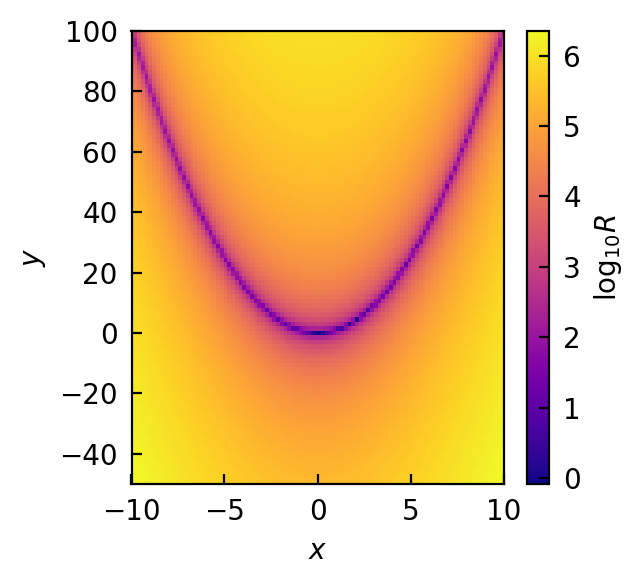

In [480]:
#xg, yg are 2D "grids" of x and y generated by meshgrid
# rg is 2D array with values of the Rosenbrock function for xg-yg grid

plot_color_map(xg, yg, np.log10(rg), xlim=[xmin,xmax], ylim=[ymin,ymax], 
                   xlabel = r'$x$', ylabel = '$y$', cmap='plasma', colorbar=True, 
                   contours=False, contcmap='plasma', cbar_label=r'$\log_{10} R$',
                   figsize=3.0)


### <font color='darkblue'>One of the simplest methods: Monte Carlo-based random walk minimization

Follows a random walk of a "*walker*" ($\mathbf{x}$ below is a vector of length $d$ - dimensionality of the parameter space where we are finding the minimum:

1. start at some initial point $\mathbf{x}=\mathbf{x}_0$. 

2. propose a step in a random direction $\mathbf{x}^\prime = \mathbf{x} + \Delta\mathbf{x}$

3. if $f(\mathbf{x}^\prime)< f(\mathbf{x})$, accept the step $\mathbf{x}=\mathbf{x}^\prime$, else go back to step 2.

Steps are terminated when some convergence is reached, for example no new step is accepted after some maximum number of proposed steps (it means that the walker is likely very close to the minimum), or accepted steps are smaller than some threshold. 


Choice of convergence criterion. Concept of ***the absolute tolerance*** parameter:

$$\mathtt{atol} > \max_{i=0,d-1}\vert x_i^\prime-x_i\vert$$ 

Components of the step vector $\Delta\mathbf{x}$ are usually chosen to follow Gaussian distribution, i.e. for a component $i$: 

$$p(\Delta x_i) = \frac{1}{\sqrt{2\pi}\,\sigma}\,\exp\left(-\frac{1}{2}\frac{\Delta x_i^2}{\sigma_i^2}\right) $$


The method requires choice of an optimal step sizes scale, $\sigma_i$. Performance and accuracy of the result will depend on this choice. However, this method is simple to implement, it does not require derivatives, and will do much better than the brute force search for a minimum. 

In [375]:
def minimize_by_random_walk(func, x0, stepsize, *args, atol=1.e-4, maxsteps=100, verbose=False):
    assert(atol > 0.) # ensure abs tolerance is positive
    nd = np.shape(x0)[0] # number of parameters
    xold = x0 + 100.*atol # initialize old location just to get things started
    xnew = x0 # initial position
    step = stepsize # initial step size
    chain = []
    nsteps = 0
    while np.abs(xnew - xold).max() > atol:
        xold = xnew
        fold = func(xold, *args)
        xtry = xold + np.random.normal(scale=step, size=nd) # generate a random Gaussian-distributed step
        while func(xtry, *args) >= fold:
            xtry = xold + np.random.normal(scale=step, size=nd)
        chain.append(xtry)
        xnew = xtry
        if verbose:
            print(xnew, np.abs(xnew - xold))
        nsteps += 1
        if nsteps > maxsteps: 
            print(f'maximum number of steps reached {maxsteps:d}')
            break

    return xnew, np.array(chain)

In [486]:
x0 = np.array([-2,2])
xmin, _ = minimize_by_random_walk(mlnrosenbrock, x0, 0.1, maxsteps=100, atol=1.e-4)
print(xmin)

KeyboardInterrupt: 

###  <font color='blue'>The Nelder-Mead (aka simplex) method</font>

There is no need for you to understand this algorithm in detail for our purposes. Just get the main idea.  Visual illustration of the algorithm, which can be found <a href="https://www.benfrederickson.com/numerical-optimization/">here</a>, can help with that.

The algorithm begins by forming an inital $(D + 1)$-dimensional polyhedron (where $D$ is the number of the minimized function parameters), or *simplex*,
of $D + 1$ points, $\mathbf{x}_i$, $i = 0, 1,\ldots, D$, that are randomly distributed throughout
the problem space domain. Indices of the points are sorted in ascending order of $f(\mathbf{x})$ so that $f(\mathbf{x}_0)$ is smallest and
$f(\mathbf{x}_D)$ is largest. It then proceeds as follows: 

1. To obtain a new trial point, $\mathbf{x}_r$, the worst point, $\mathbf{x}_D$, is reflected through the opposite face of the polyhedron using a scaling factor, $s_1$:

$$\mathbf{x}_r=\mathbf{x}_D + s_1\,(\mathbf{x}_m - \mathbf{x}_D),$$

where $\mathbf{x}_m$ is mean (the centroid) of all $\mathbf{x}$, excluding $\mathbf{x}_D$:

$$\mathbf{x}_m = \frac{1}{D}\,\sum\limits_{i=0}^{D-1}\mathbf{x}_i.$$

For example, when $D = 2$, the simplex is a triangle.

###  <font color='darkblue'>Examples of simplex transformations that can occur during algorithm

<п>
<center>
<img width=700 src="https://www.researchgate.net/publication/331485312/figure/fig1/AS:732572388712448@1551670276072/Operations-in-the-Nelder-Mead-simplex-algorithm.ppm"></img>

[Visualization](https://www.benfrederickson.com/numerical-optimization/) of how the method works in 1D and 2d. 

2. If $f(\mathbf{x}_r)<f(\mathbf{x}_0)$, then take another step in the same direction with scaling factor of $s_2$:

$$\mathbf{x}_e=\mathbf{x}_r + s_2\,(\mathbf{x}_m - \mathbf{x}_D),$$

If $f(\mathbf{x}_e)<f(\mathbf{x}_0)$, then $\mathbf{x}_D=\mathbf{x}_e$ and we go to step 1 above, else
    $\mathbf{x}_D=\mathbf{x}_r$.
    
3. Else if $f(\mathbf{x}_r)>f(\mathbf{x}_0)$, compare $f(\mathbf{x}_r)$ to $f(\mathbf{x}_{D-1})$ and if $f(\mathbf{x}_r)$ is smaller $\mathbf{x}_{D-1}=\mathbf{x}_r$, if not than *shrink the entire simplex* by the scaling factor of $s_3$.

This description is not fully complete, as there are a number of checks and choices made in the last step. It is meant to give an idea of how the algorithm works. It'd be easier to examine the pseudo-code for the algorithm given below.

<img width=500 src="http://astro.uchicago.edu/~andrey/classes/a211/img/simplex_pseudo_code.PNG"></img>

Using Nelder-Mead (simplex) minimization method that does not rely on function derivatives to find the minimum of the Rosenbrock function.  

In [ ]:
from scipy.optimize import minimize

x0 = [-10, 10] # 2d version 
#x0 =  np.array([0.5, 0.5, 0.5, 0.5, 0.5])
#x0 = np.array([-10, 10, -5, 10, 5])

tstart = default_timer()
res = minimize(mlnrosenbrock, x0, method='nelder-mead', tol=1.e-12)
print("completed in %.3g sec"%(default_timer() - tstart))

print("minimum at :",res.x)

###  <font color='blue'>The Differential Evolution method</font>

Developed by R. Storn and K. Price in 1997 (<a href="https://link.springer.com/article/10.1023%2FA%3A1008202821328">Storn & Price 1997</a>), the <a href="https://en.wikipedia.org/wiki/Differential_evolution">differential evolution algorithm</a> is remarkably simple to implement, works in arbitrary number of dimensions, does not require function derivatives, allows imposing bounds on the domain, and is quite efficient. 


<p>
    
<img width=700 src="https://pablormier.github.io/assets/img/de/ackley.gif"></img>

Start with $N_p$ members of the population randomly distributed in the problem domain. Vector of coordinates for each member is indexed from $0$ to $N_p-1$ and collection of all vectors $\mathbf{X}_{\rm now}=(\mathbf{x}_{\rm now,0},\mathbf{x}_{\rm now,1},\ldots,\mathbf{x}_{{\rm now},N_p-1})$ forms the current population, where each $\mathbf{x}_{\rm now,i}$ is a $D$-dimensional vector, where $D$ is the number of parameters of the minimized function.   

The algorithm then proceeds through iterations (called evolutionary or generational cycles) that lead to evolution of the population towards function minimum.

The reason the method is called "differential evolution" is because the initial population of points in $D$ dimensions can be thought of as evolving towards a minimum during algorithm iterations. The evolution is differential because it is driven by scaled differences between member locations. 

In depth description of the differential algorithm, its variations, tests, and applications can be found in a book by R. Storn, K. Price and J. Lampinen "*Differential evolution : a practical approach to global optimization*" <a href="https://catalog.lib.uchicago.edu/vufind/Record/8875926">available online</a> through U.Chicago library. 

 Each iteration (evolution cycle) consists of the "*mutation*" and "*selection*" stages for each point vector $\mathbf{x}_i$ in $\mathbf{X}_{\rm now}$ (each member of the population) that leads to formation of the new population $\mathbf{X}_{\rm next}$:

* *Mutation stage for element $i$:*  select three random indices from $0$ to $N_p-1$, $r_1$, $r_2$, $r_3$ *different* from $i$. 
Perturb element with index $r_3$ by the scaled difference of vectors with indices $r_2$ and $r_1$: 
$\mathbf{x}^\prime_i=\mathbf{x}_{{\rm now}, r_3} + s\,(\mathbf{x}_{{\rm now}, r_2}-\mathbf{x}_{{\rm now}, r_1})$, where $s$ is a parameter. $s$ is usually a random number. 


* *Selection stage:* if $f(\mathbf{x}^\prime_i)\leq f(\mathbf{x}_{{\rm now},i})$, then $\mathbf{x}_{{\rm next},i}=\mathbf{x}^\prime_i$, else $\mathbf{x}_{{\rm next},i}=\mathbf{x}_{{\rm now},i}$ (no mutation). 

Once all members of the population went through mutation and selection stages go back to the next iteration and $\mathbf{X}_{\rm next}$ becomes $\mathbf{X}_{\rm now}$ and the cycle repeats. 

Evolutionary cycles continue until some convergence criterion is met. For example, maximum difference between vectors in $\mathbf{X}_{\rm next}$ and $X_{\rm now}$ is smaller than the specified threshold. 

Differential evolution method is implemented in <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution"><tt>scipy.optimize.differential_evolution</tt></a> function. 

Here is pseudo-code for the simplest version of the differential evolution algorithm, which already should work quite well, but can be further improved by various modifications. 

<code>
    npop = np.size(x0)[0] # the number of population members
    fnow = func(xnow)
    xnow = np.copy(x0)
    xnext = np.zeros_like(xnow)
    ....
    while some convergence criterion is not met: 
        # xnow is a vector of coordinate vectors of the current population
        # xnext is a vector of coordinate vector of the next gen population
        for i in range(npop):
            # generate random unique indices  ir1, ir2, ir3 
            # where all indices are not equal to each other and not equal to i
            # s can be a constant for large npop, but it's more safe to make it a random number
            xtry = xnow[ir3] + s * (xnow[ir1] - xnor[ir2])
            if func(xtry) <= fnow[i]:
                xnext[i] = xtry
            else:
                xnext[i] = xnow[i]
</code>

In [157]:
inds = np.arange(10)
inds = np.delete(inds,7)
np.random.shuffle(inds)
print(inds[0], inds[1], inds[2])

3 4 8


###  <font color='blue'>The Differential Evolution method: initial distribution of members</font>

Mutation stage of the algorithm requires that population members are in different locations, otherwise the difference $\mathbf{x}_{{\rm now}, r_2}-\mathbf{x}_{{\rm now}, r_1}$ will be zero and location of $\mathbf{x}_{{\rm now}, r_3}$ will simply be duplicated to location of $\mathbf{x}^\prime_i$ in the mutation stage.

Thus, initial population members positions must be different. There are different ways to place population members. Assuming that we are searching for a minimum within some rectangular domain defined by the minimum and maximum values along each coordinate axis: $\mathbf{x}_{\rm min}$ and $\mathbf{x}_{\rm max}$, we can initialize the members as 

$$\mathbf{x}_0 = \mathbf{x}_{\rm min} + (\mathbf{x}_{\rm max}-\mathbf{x}_{\rm min}) \times \mathrm{rand}(0,1),$$

where $\mathrm{rand}(0,1)$ is a random number uniformly distributed from 0 to 1 (can be produced with <tt>np.random.uniform</tt>, for example). 


This choice makes sense if we do not know the location of the minimum and we are spreading the population members as widely as possible. To make the distribution of members more uniform, certain placement strategies can be used instead of random distribution above, such as <a href="https://www.johndcook.com/blog/2009/03/16/quasi-random-sequences-in-art-and-integration/">quasi-random sequences</a>.

Another possibility is to initialize locations of population members around a given point $\mathbf{x}_{0c}$ by using random numbers drawn from a Gaussian distribution centered at $\mathbf{x}_{0c}$ with some non-zero dispersion around it. 

 This choice makes sense if we have a good idea where the minimum is roughly, so that we can choose $\mathbf{x}_{0c}$ to be near the suspected location. 

### <font color='blue'>Choosing $s$ scaling factor</font>


To avoid this different members stepping to the location, $s$ for each population is chosen to be a random number drawn from a distribution. Common choices: 


    * Gaussian distribution with the mean at some $s_{\rm mean}$ and dispersion $\sigma_s$.<p> 


    * Uniform distribution $U(a,b)$. 


The choice that seems to work well in practice is $U(s,1)$, where $s\approx 0.1-0.3$. 

# <font color='blue'>ASTR 21100</font> 

# <font color='blue'>"Computational Techniques in Astrophysics"</font>

# <font color='blue'>Methods for sampling from 1-dimensional probability distributions</font>


In [2]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier
plot_prettier()

### <font color='blue'>Sampling random numbers from a 1-dimensional probability distribution function (pdf)</font>

Such sampling involves two steps: 

1) a sequence of random, uniformly distributed numbers in the $[0,1]$ interval (this is handled by PRNG codes, see <a href="https://drive.google.com/file/d/1x3KUR8vqs-O7DDqJYUaT-0xA8x6Yh5oK/view?usp=sharing"><tt>08b_prngs.ipynb</tt></a>)

2) a transformation of that sequence from the uniform pdf to a desired (target) pdf.

### <font color='blue'>Definitions of the pdf and cdf</font>

* **Probability distribution function (pdf)** (sometimes called probability density function), $p(x)$, is a ***positive*** function, $p(x)\geq 0$, defined such that $p(x)dx$ measures probability for $x$ to be in the interval $[x,x+dx)$. 

If pdf is defined on an interval $x\in [a,b]$, integral over this interval for a properly normalized pdf is 

$$\int\limits_a^b p(x)dx=1$$

because probability of any $x$ should be 1 by definition. So pdf is always 0 or positive and normalized such that integral over the interval for which it is defined is equal to 1.


* **Cumulative distribution function (cdf)** is defined as 

$$P(x) = \int\limits_b^x p(x^\prime) dx^\prime.$$
If $p(x)\geq 0$ and is normalized as above, it is clear that $P$ varies monotonically from $0$ to $1$, as $x$ increases from the lower to the upper limits of the interval on which $p(x)$ is defined. 

**Note 1.** Whether pdf must be so normalized depends on its application. If we need only ratios such as $p(x_2)/p(x_1)$ then normalization is not relevant. Thus, for certain methods, such as MCMC normalization is not important.  

**Note 2.** Given that $p(x)dx$ is probability, which is dimensionless, if $x$ has some dimension (for example, grams), then $p(x)$ also must have dimension of $[x^{-1}]$ (i.e., inverse grams) so that product of $p(x)$ and $dx$ is dimensionless. Remembering that pdf has dimensions inverse of the dimension of its parameter is useful when algebraic operations with pdfs are performed, as we will see later. 

### <font color='blue'>Random sampling from pdfs</font>

The two simplest and widely used methods to sample non-uniform 1-dimensional pdfs (or in some cases low-dimensional ones) -- the inverse transform sampling and rejection sampling -- were laid out on one page in a letter by John von Neumann to Stanislaw Ulam written on May 21, 1947. 

The latter was known previously in a different context (geometric estimates of probability), but it was von Neumann who re-invented rejection sampling and made it popular in the context of Monte Carlo methods. 

<p>
<center><img width=400 src="https://astro.uchicago.edu/~andrey/classes/a211/img/John_von_Neumann-LosAlamos.gif"></img></center>
</p>

### <font color='blue'>Random sampling from 1d pdf $p(x)$</font>


<center><img width=600 src="https://astro.uchicago.edu/~andrey/classes/a211/img/von_neumann_letter1.png"></img></center>

The inverse transform sampling is the most useful method in practice and is discussed in detail below. Rejection method is conceptually simpler, but is not as useful due to its inefficiency in general cases, especially for pdfs with a wide range of values, such as exponential or power law pdfs. 

### <font color='blue'> Rejection method</font>

If we know maximum value of $p(x)$, $p_{\rm max}=\max\limits_{x\in[a,b]} p(x)$ at the interval $[a,b]$ in which we are sampling, we can get sample of $x$ values that follow $p(x)$ distribution using a simple procedure. 

We can draw $x$ randomly in $[a,b]$ and accept or reject it with probability $p(x)$. To do this we draw a random number $y$ uniformly distributed in $[0,p_{\rm max}]$ and if $y\leq p(x)$ we accept it, otherwise we reject it and draw another $x$ value. 

In [160]:
n = 10000
prob = 0.05
f = np.random.normal(size=n)
x = np.random.uniform(size=n)
fsel = f[x<prob]
print(f'selected randomly {fsel.size*100/n:.2f} percent of the sample')

selected randomly 5.18 percent of the sample


### <font color='blue'> Inverse transform sampling (ITS) method</font>

For a sample of $x_i$ values drawn from $p(x)$ pdf which has cdf $P(x)$, we expect that $y_i = P(x_i)$ are uniformly distributed in $y\in [0,1]$. 

This method uses this statement in the reverse order: if I have samples $y_i$ drawn from the uniform pdf defined in $y\in [0,1]$, then $x_i$ values defined by equation 

$$y_i=P(x_i)$$

will follow $p(x)$ pdf. That's all there is to this method. All we need to handle is how to solve this equation for $x_i$ values. 


### <font color='blue'> Illustration: sampling from $p(x)=e^{-x}$ defined at $x\in [0,\infty)$</font>


In [126]:
def pdf_exp(x, beta=1.):
    return beta*np.exp(-beta*x)

def cdf_exp(x, beta=1.):
    return 1.-np.exp(-beta*x)

def cdf_exp_inv(x, beta=1):
    return -beta*np.log(1-x)


In [122]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec

plot_prettier()

In [127]:
def its_demo(figsize=(3,3), xlims=[0,7], cdf=None, cdfi=None, nl=10):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'cdf   $P(x)$')
    ax.set_xlim(xlims)
    ax.set_ylim(0, 1)
    ax_b.set_xlim(xlims)
    ax_l.set_ylim(0.,1)
    x = np.linspace(xlims[0], xlims[1],100)
    ax.plot(x, cdf(x), lw=2, c='slateblue', label='cdf')
    yl = np.linspace(0.,1., nl)
    xl = cdfi(yl)
    for i in range(nl):
        ax.plot([0, xl[i]], [yl[i], yl[i]], ls='--', c='gray', lw=0.5)
        ax.plot([xl[i], xl[i]], [0, yl[i]], ls='--', c='gray', lw=0.5)
    #ax.legend(frameon=False, loc='lower right')
    plt.show()



<IPython.core.display.Javascript object>


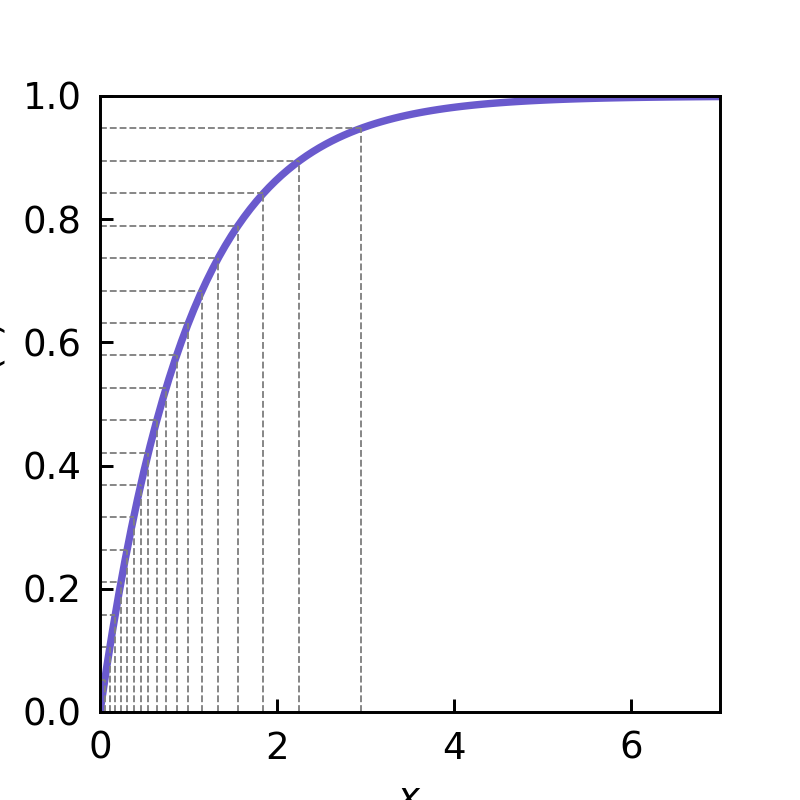

C:\Users\akrav\AppData\Local\Temp\ipykernel_22228\4072937399.py:8: RuntimeWarning: divide by zero encountered in log
  return -beta*np.log(1-x)


In [128]:
its_demo(cdf=cdf_exp, cdfi=cdf_exp_inv, nl=20)

<IPython.core.display.Javascript object>


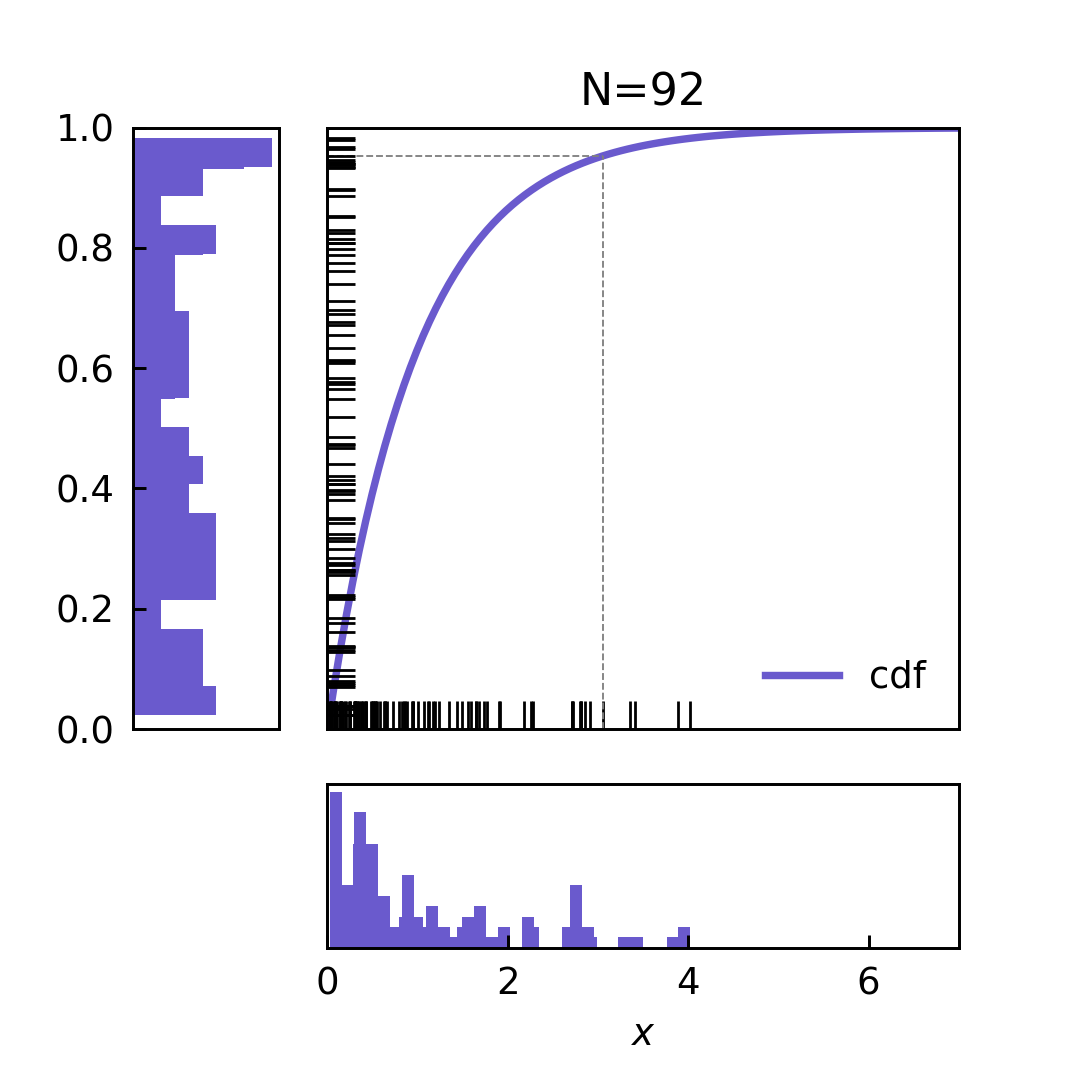

In [146]:
nr = 1000
d = np.random.uniform(size=nr)
xlims=[0,7]
cdf = cdf_exp
cdfi = cdf_exp_inv
pdf = pdf_exp

fig = plt.figure(figsize=(4,4))
gs = GridSpec(8,9, wspace=1, hspace=1)
ax_l = fig.add_subplot(gs[:6,:2])
ax = fig.add_subplot(gs[:6,2:])
ax_b = fig.add_subplot(gs[6:,2:])
#ax_l.axes.yaxis.set_visible(False)
ax_l.axes.xaxis.set_visible(False)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax_b.axes.yaxis.set_visible(False)

ax.set_xlim(xlims)
ax.set_ylim(0, 1)
ax_b.set_xlim(xlims)
ax_l.set_ylim(0.,1)
x = np.linspace(xlims[0], xlims[1],100)
ax.plot(x, cdf(x), lw=2, c='slateblue', label='cdf')
ax.legend(frameon=False, loc='lower right')
ax_b.set_xlabel('$x$')

def its_anim(i, savefig=False):
    ci = cdfi(d[i])
    di = d[i]

    ax.lines.remove(its_anim.l1)
    ax.lines.remove(its_anim.l2)
    ax.plot(ci, 0., '|k', ms=15, markeredgewidth=0.75)
    its_anim.l1, = ax.plot([0, ci], [di, di], ls='--', c='gray', lw=0.5)
    its_anim.l2, = ax.plot([ci, ci], [0, di], ls='--', c='gray', lw=0.5)
    ax.plot(0.0, di, '_k', ms=15, markeredgewidth=0.75)
    _, bins, _ = ax_b.hist(cdfi(d[:i]), bins=30, color='slateblue');
    xl = np.linspace(xlims[0], xlims[1], 100)
    _, ybins, _ = ax_l.hist(d[:i], bins=20, orientation="horizontal", color='slateblue');
    ax.set_title(f'N={d[:i].size:d}')
    if savefig: fig.savefig(f'its_frames/f{i:04d}.png')

its_anim.l1, = ax.plot([0, 0], [0, 0], ls='--', c='gray', lw=0.5)
its_anim.l2, = ax.plot([0, 0], [0, 0], ls='--', c='gray', lw=0.5)

animation = FuncAnimation(fig, its_anim, interval = 200)

plt.show()

### <font color='blue'>  Example of using the ITS method: sampling an exponential pdf</font>

Application of the method is pretty straightforward if the equation can be solved for $x_i$ explicitly. For example, consider exponential pdf $p(x) = Ae^{-\beta x}$ for $\beta>0$ and $x\in [0,\infty)$.

$A$ is normalization factor ensuring that $p(x)$ is pdf: 

$$A\int\limits_0^\infty e^{-\beta x}dx = 1; \ \ \ {\rm i.e.}\ \ \rightarrow\ \ A = \frac{1}{\int_0^\infty e^{-\beta x}dx} = [x\rightarrow\tilde{x}=-\beta x]=\frac{1}{-(1/\beta)\int_0^{-\infty} e^{\tilde{x}}d\tilde{x}}=\frac{\beta}{\int^0_{-\infty} e^{\tilde{x}}d\tilde{x}}=\beta$$


So our pdf is $p(x) = \beta\, e^{-\beta x}$ and its cdf is 

$$P(x) = \beta\,\int\limits_0^x e^{-\beta x}dx = [x\rightarrow\tilde{x}=-\beta x]=-{\beta\over\beta}\,\int\limits_0^{\tilde{x}} e^{\tilde{x}}d\tilde{x} = \int\limits^0_{\tilde{x}} e^{\tilde{x}}d\tilde{x} = 1- e^{-\beta x}$$

and we can simply solve for $x$ algebraically: 

$$x(P) = -\frac{1}{\beta}\,\ln[1-P]$$

Now all we need to do to draw $n$ random numbers from the exponential distribution $p(x)=\beta\,e^{-\beta x}$ is to: 

* generate $n$ samples $y_i$ uniformly distributed in $[0,1]$


* transform them into $x_i = -1/\beta\ln[1-y_i]$.


Note that $x_i = -1/\beta\ln[1-y_i]=-1/\beta\ln\,y_i$ because if $y_i$ is a number uniformly distributed in $[0,1]$, so is $1-y_i$. 

In [161]:
def exp_pdf(x, beta):
    """
    normalized exponential PDF p(x)= e^{-x\beta}\beta
    
    Parameters:
    -----------
    x: 1d numpy array of real numbers 
    beta: a real non-zero number
        
    Returns:
    --------
    a 1d numpy vector of real numbers equal to the PDF values at input x values
    """
    return np.exp(-x*beta) * beta


In [162]:
def invcdf_exp(y, beta):
    """
    analytic inverse of the exponential CDF
    """
    assert(beta != 0.)
    
    return -np.log(1.-y) / beta

nr = 1000000
# generate a vector of nr uniformly distributed numbers over [0.,1.]
yrnd = np.random.uniform(0., 1., nr)

beta = 3.0
xexp = invcdf_exp(yrnd, beta)

In [163]:
def plot_pdf(xr, plot_pdf=True, func=None, args=None,
             xlabel='$x$', ylabel='$p(x)$',  label='samples', 
             bins = 50, xlog=False, ylog=True, 
             xlims=[0.,30.], ylims=[1.e-6, 0.4], figsize=5):
    """
    a utility function to plot samples from a pdf as a histogram and compare
    the histogram to the analytical form of the pdf plotted as a line, if needed
    
    Parameters:
    -----------
    xr:           1d numpy array of float numbers: vector of samples
    plot_pdf:     boolean, determines whether to plot a line of the target pdf
                  if True, func needs to be supplied
    func:         Python function object: function that returns analytic pdf for a given vector xr
    args:         list of possible arguments to func, if any
    xlabel, ylabel: strings, labels for x and y axes
    label:        string, label for the samples histogram for the legend
    bins:         integer or string (e.g., 'auto'), passed on as bins parameter to Pylab's histogram function
    xlog, ylog:   boolean, determine whether x or y axis is to be plotted on logarithmic scale
    xlims, ylims: lists of 2 float elements defining plot limits for x and y axes
    figsize:      float, parameter controlling plot size 
    
    Returns:
    --------
    Nada
    """
    plt.figure(figsize=(figsize,figsize))
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    if xlog: plt.xscale('log') # plot y-values on a logarithmic scale
    if ylog: plt.yscale('log') # plot y-values on a logarithmic scale
    plt.xlim(xlims); plt.ylim(ylims) # set axis limits 

    # compute histogram values; 
    # density='True' normalizes histogram properly so it can be compared to pdf
    hist, bins, patches = plt.hist(xr, density='True', color='slateblue', bins=bins, label=label)
    # compute bin centers using numpy slicing 
    binc = 0.5*(bins[1:] + bins[:-1])
    if plot_pdf: 
        plt.plot(binc, func(binc, *args), lw=1.25, c='orangered', label='target pdf')
    plt.ylabel(r'$p(x)$') # label axis 
    plt.xlabel(r'$x$')
    plt.legend(loc='best', frameon=False, fontsize=3*figsize)
    plt.show()

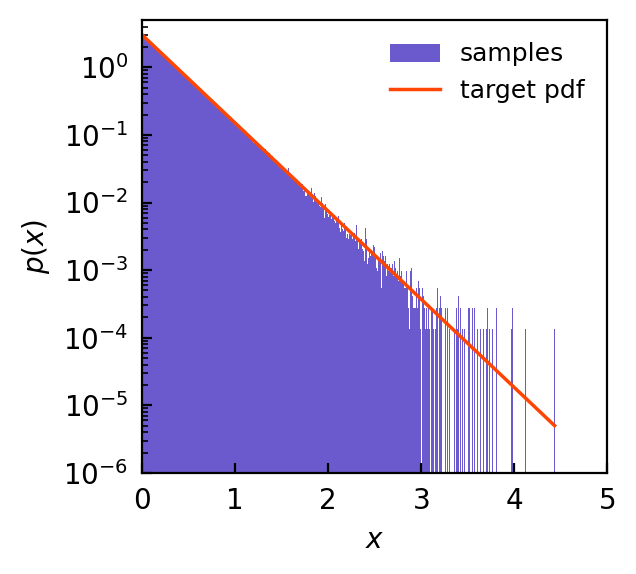

In [165]:
%matplotlib inline
plot_prettier()

plot_pdf(xexp, func=exp_pdf, args=[beta], xlims=[0,5], ylims=[1.e-6,5], 
         bins='auto', xlabel=r'$x$', ylabel=r'$p(x)$', figsize=3)

### <font color='blue'>Why does the inverse transform method work? geometric interpretation</font>

The meaning of the method can be grasped by visualizing the cumulative pdf, $y=P(x)$ in the $x-y$ plane. Suppose we draw samples from the uniform distribution along $y$: i.e., $u_{[0,1]}=1$ for $y\in[0,1]$. The probability of a sample to fall within some interval $dy$ is $u_{[0,1]}dy=dy$ for $y\in [0,1]$. What will be the corresponding interval $dx$ along $x=P^{-1}(y)$ axis that corresponds to $dy$? 

Geometrically, $dx = dy/\tan\alpha= dy/(dP/dx) = dy/p(x)$, where $\alpha$ is the local slope of the cdf,  $\tan\alpha(x) = dP/dx=p(x)$, where the latter identity holds by the definition of cdf:

$$\frac{dP(x)}{dx} = \frac{d}{dx}\int\limits_{-\infty}^x p(x)dx = p(x)$$


Thus, uniform distribution of points in the vertical $y$ axis will turn into distribution of points in the horizonthal $x$ axis with density function $p(x)$, because $dy = p(x)dx$, which is precisely what we want.

### <font color='blue'>Why does the inverse transform method work? formal proof (read if you care)</font>


**Theorem.** if samples $x_i$ are drawn from pdf $p(x)$, the distribution of $P(x_i)$ will be uniform in the range $[0,1]$.

**Proof.**  Let's examine what kind of transformation $y(x)$ will convert these numbers into uniformly distributed  $y_i=y(x_i)$ in the interval $[0,1]$  


We know that pdfs are transformed using "conservation of probability equation": 

$$p(x)dx = g(y)dy,$$ 

so for a given transformation $y(x)$, the pdf of $y$ will be 

$$g(y) = p(x)\, {dx\over dy} = {p(x)\over y^\prime},$$ 

where $y^\prime=dy/dx$ is derivative of $y(x)$ wrt $x$. 

Thus, if $y^\prime = p(x)$, then $g(y)=1$, which is a uniform pdf in the interval $y\in[0,1]$. 

However, the function derivative of which wrt $x$ is $p(x)$ is its cdf $P(x)$ by definition: 

$$\frac{dP(x)}{dx} = \frac{d}{dx}\int\limits_{-\infty}^x p(x)dx = p(x),\ \ \ {\rm and\ thus}\ \rightarrow\ y(x)=P(x).$$

Thus, this result tells thus that for $x_i$ drawn from pdf $p(x)$, which has cdf $P(x)$, $y_i=P(x_i)$ will be distributed uniformly in the interval $y\in [0,1]$. 

## <font color='blue'>Sampling special case pdfs: drawing Gaussian random numbers and distributions symmetric around zero (optional material)</blue>

The Gaussian numbers can be drawn using the inverse transform, but this is computationally expensive due to a relatively complicated cdf of the Gaussian distribution (error function). Thus, a more efficient method is usually used: most commonly used is the <a href="https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform">Box-Mueller method.</a>. 

If $u_1$ and $u_2$ are uniformly distributed random numbers in the interval $[0,1)$, the following two numbers are drawn from the Gaussian pdf of zero mean and variance $\sigma^2=1$:


$$g_1=\sqrt{-2\ln u_1}\cos 2\pi u_2;\ \ \ g_2=\sqrt{-2\ln u_1}\sin 2\pi u_2 $$


If we want Gaussian numbers that sample Gaussian pdf with a given mean $\mu$ and standard deviation $\sigma$, we can rescale the above numbers as (where $g$ is either $g_1$ or $g_2$):

$$\tilde{g}=\mu + \sigma\,g$$


Let's check this empirically. 

The method is named after George Edward Pelham Box and Mervin Edgar Muller, who <a href="https://projecteuclid.org/euclid.aoms/1177706645">proposed it in 1958</a>, although the method was previously developed by Raymond E. A. C. Paley and Norbert Wiener in 1934.

In [166]:
# generate two vectors of nr pseudo-random numbers uniformly distributed in [0,1] (default)
nr = 100000
u1 = np.random.uniform(size=nr)
u2 = np.random.uniform(size=nr)

# transform uniformly distributed numbers in u1 and u2 into Gaussian pdf samples
mu, sigma = 10, 10 
g1 = 10. + 10.*np.sqrt(-2.*np.log(u1)) * np.cos(2.*np.pi*u2)
# g2 will stay with mu=0 and sigma=1
g2 = np.sqrt(-2.*np.log(u1)) * np.sin(2.*np.pi*u2)

In [167]:
def gaussian_pdf(x, mu=0., sigma=1.):
    """
    returns value of the Gaussian pdf with input mu, sigma for input x 

    Parameters:
    -----------
    x:     a float or a 1d numpy array of floats, input x value(s)
    mu:    a float, mean of the Gaussian (default 0)
    sigma: a float, st. deviation of the Gaussian (default 1.0)
    
    Returns:
    --------
    
    g(x): a float or a 1d numpy array of floats, 
          value(s) of the Gaussian pdf for input x value(s)
    """
    assert(sigma !=0.)

    return 1./np.sqrt(2.*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

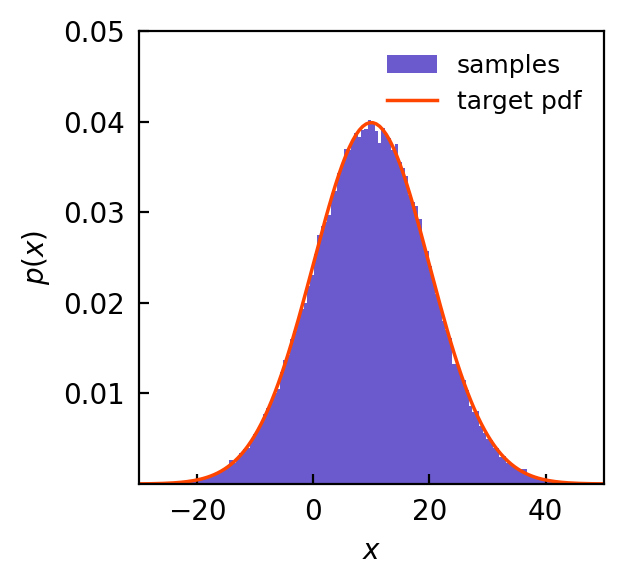

In [168]:
g = np.random.normal(size=nr)
plot_pdf(g1, func=gaussian_pdf, args=[mu, sigma], xlims=[-30,50],
         ylims=[1.e-6,0.05], ylog=False, 
         bins='auto', xlabel=r'$x$', ylabel=r'$p(x)$', figsize=3)

Using Gaussian samples you can also create samples of some other distributions, such as $\chi^2$ and Student $t$ distribution.

When a large number of samples is needed and computational time is an issue, there is a more efficient <a href="https://en.wikipedia.org/wiki/Ziggurat_algorithm">*ziggurat algorithm*</a> of Marsaglia & Tang (2000) to sample symmetric unimodal distributions such as Gaussian and Student $t$. However, this algorithm won't work for assymetric distributions such as $\chi^2$.  

## <font color='blue'>Generating correlated random samples (optional for undergraduate students)</font>

In practical applications one often needs to generate correlated random numbers reflecting correlations in the underlying model. 

Suppose we have a sequence of $N$ ($N\geq 2$) *uncorrelated* random numbers with zero mean and unit variance, $\vec{x}=\{x_i\}$, $\langle \vec{x}\rangle=0$ and $\langle\vec{x}\cdot\vec{x}^T\rangle = I,$
where $I$ is a unitary matrix and angle brackets denote averaging. 

We want to generate a sequence of $N$ correlated random numbers, $\vec{y}=\{y_i\}$, with correlations given by *covariance matrix*, $C\equiv \langle \vec{y}\cdot\vec{y}^T\rangle$, with elements 
\begin{equation}
C_{ij}=\frac{1}{N_s-1}\sum\limits_{k=1}^{N_s}(y_{ik}-\langle{y}_i\rangle)(y_{jk}-\langle{y}_j\rangle),
\end{equation}
where averaging is done over some number $N_s$ of sample realizations of $\vec{y}$.

Thus, given a vector of uncorrelated random numbers $\vec{x}$ to generate a vector of random samples $\vec{y}$ correlated among each other with correlations given by the covariance matrix $C$, we need to find a transformation matrix $M$ that satisfies the following two equations:
\begin{equation}
\vec{y}=M\cdot \vec{x},\ \ \ C=\langle\vec{y}\cdot\vec{y}^T\rangle.
\end{equation}

Substituting the left equation into the right one and taking into account that $\vec{x}$ has unit variance, we have:
\begin{equation}
C=\langle M\cdot \vec{x}\cdot\vec{x}^T\cdot M^T\rangle = M\cdot\langle\vec{x}\cdot\vec{x}^T\rangle\cdot M^T=M\cdot M^T.
\end{equation}

In other words, $M$ is the result of a decomposition of $C$ into a product of a matrix and its transpose. 

### <font color='blue'>Computing $M$ using Cholesky decomposition</font>

For a covariance matrix that is by its definition symmetric and positive-definite, the most efficient way to achieve this is to use the *Cholesky decomposition*: $C=L\cdot L^T$, where  $L$ is the lower triangular matrix. 

So the matrix $M$ we are seeking is the lower rectangular matrix resulting from the Cholesky decomposition of the covariance matrix $C$.
Standard linear algebra libraries always include a Cholesky decomposition function (e.g., <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html"><tt>numpy.linalg.cholesky</tt></a> in numpy).

The required correlated numbers drawn from the same distribution as $\{x_i\}$ but which have the required covariance matrix and mean $\langle\vec{y}\rangle$ are then given by 
\begin{equation}
\vec{y}=\langle\vec{y}\rangle + L\cdot\vec{x},\ \ \ \mathrm{or}\ \ \ \ y_i=\langle y_i\rangle + \sum\limits_{j=1}^N L_{ij} x_j.
\end{equation}

### <font color='blue'>Importance sampling (optional for everyone)</font>

Often we are interested not in the samples from a given distribution $p(x)$ themselves, but rather in averages of various quantities over that distribution. For example, average of function $g(x)$ over $p(x)$ distribution:

$$
\bar{g}_{p} = \int\limits_a^{b}g(x)p(x)dx \approx \frac{1}{N_s}\sum\limits_{i=1}^{N_s} g(x_{i,p}),\ \ \mathrm{where}\ \ x_{i,p}\sim p(x),
$$
where the last part indicates that $x_{i,p}$ are samples drawn from $p(x)$.

If this is the case and $p(x)$ is a distribution that's difficult to sample from, we can choose a function, $q(x)$, called the *importance* function, that's easy to sample from, and re-write the expression for $\bar{g}_p$ as

$$
\bar{g}_{p} = \int\limits_a^{b}g(x)\,\frac{p(x)}{q(x)}\, q(x)dx \approx \frac{1}{N_s}\sum\limits_{i=1}^{N_s} g(x_{i,q})\,\frac{p(x_{i,q})}{q(x_{i,q})},\ \ \mathrm{where}\ \ x_{i,q}\sim q(x).
$$

Thus, we can get an estimate of an average (or any other moment) over a given distribution, by sampling from a different distribution. Note that for numerical stability reasons, $p/q$ ratio should never be overly large. Thus $q(x)$ is chosen in such a way that $p(x)/q(x)$ goes to zero or varies mildly as $p(x)$ goes to zero. 

The importance sampling is useful not only because it allows to compute averages over distribution by sampling an easier to sample distribution, but also because
such averages can be more accurate than the straightforward average over $p(x)$. This is because sampling from $q(x)$ can concentrate the samples into *important* regions that contribute the most to the integral. 